In [4]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/Projects/BIASlab/ThesisParallelMP`


In [5]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, Parameters, ProgressMeter, StableRNGs

In [6]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (6, 0)


(6, 0)

In [7]:
includet("../parallel.jl")

In [8]:
function generate_data(rng, n)
    return sin.(range(1, 4.0; length = n)) .+ 0.1 * rand(rng, n)
end

generate_data (generic function with 1 method)

In [34]:
struct NormalMeta
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ = q_μ, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:μ, Marginalisation) (q_out::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:μ, Marginalisation) (q_out = q_out, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:out, Marginalisation) (m_μ::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:μ, Marginalisation) (m_out::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = PointMass(mean(q_v) + s))
end

@average_energy NormalMeanVariance (q_out_μ::MultivariateNormalDistributionsFamily, q_v::Any, meta::NormalMeta) = begin
    out_μ_mean, out_μ_cov = mean_cov(q_out_μ)
    return (ReactiveMP.log2π + mean(log, q_v) + mean(inv, q_v) * (out_μ_cov[1, 1] + out_μ_cov[2, 2] - out_μ_cov[1, 2] - out_μ_cov[2, 1] + abs2(out_μ_mean[1] - out_μ_mean[2]))) / 2
end

In [41]:
struct GammaMeta
	size::Int
end

@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::PointMass, q_τ::Any, meta::GammaMeta) = begin 
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanPrecision(:μ, Marginalisation) (q_out = PointMass(mean(q_out) + s), q_τ = q_τ)
end

@rule NormalMeanPrecision(:τ, Marginalisation) (q_out::PointMass, q_μ::Any, meta::GammaMeta) = begin 
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out = PointMass(mean(q_out) + s), q_μ = q_μ)
end

@average_energy NormalMeanPrecision (q_out::Any, q_μ::Any, q_τ::Any, meta::GammaMeta) = begin
    μ_mean, μ_var     = mean_var(q_μ)
    out_mean, out_var = mean_var(q_out)
    return (ReactiveMP.log2π - mean(log, q_τ) + mean(q_τ) * (μ_var + out_var + abs2(μ_mean - out_mean))) / 2
end

In [90]:
@model function state_space_model(n, size, prod_strategy, pipeline_states, pipeline_shared)
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    τ_y = randomvar() where { prod_strategy = prod_strategy }
    # As well a sequence of observartions
    y = datavar(Float64, n)

    states_meta = NormalMeta(size)
    precision_meta = GammaMeta(size)

    x0 ~ Normal(mean = 0.0, precision = 1.0)
    τ_y ~ Gamma(shape = 1.0, rate = 1.0)

    x_i_min = x0

    for i in 1:n
        x[i] ~ Normal(mean = x_i_min, variance = 1.0) where { pipeline = pipeline_states, meta = states_meta }
        y[i] ~ Normal(mean = x[i], precision = τ_y) where { pipeline = pipeline_shared, meta = precision_meta }
        x_i_min = x[i]
    end
end

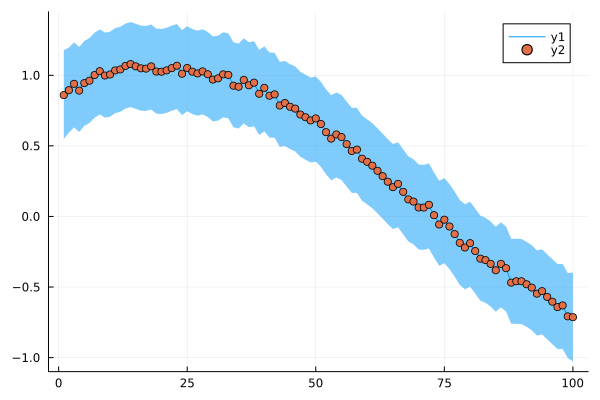

In [114]:
seed = 123
rng  = StableRNG(seed)
n = 100

data = generate_data(rng, n);

constraints = @constraints begin
    q(x0, τ_y, x) = q(x0, x)q(τ_y)
end

results = infer(
    model = state_space_model(n, 10, nothing, ThreadsReusingPipelineStage(vague(NormalMeanVariance)), ThreadsPipelineStage()),
    data  = (y = data,),
    iterations    = 20,
    returnvars    = KeepLast(),
    options       = (limit_stack_depth = 100, ),
    initmarginals = (τ_y = Gamma(100.0, 100.0), ),
    constraints  = constraints,
    free_energy = true
);
plot(mean.(results.posteriors[:x]), ribbon = std.(results.posteriors[:x]))
scatter!(data)

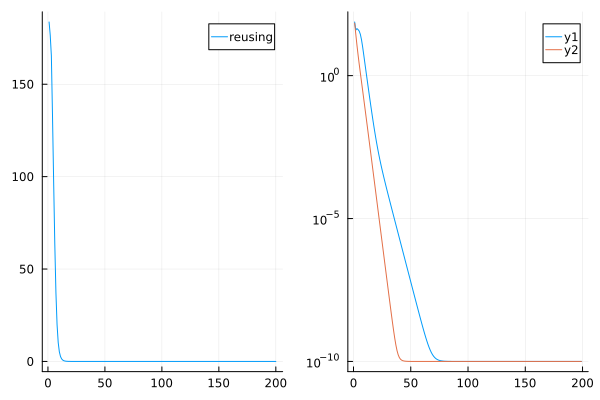

In [131]:
niterations = 200
results1 = infer(
    model = state_space_model(n, 10, nothing, ThreadsReusingPipelineStage(vague(NormalMeanVariance)), ThreadsPipelineStage()),
    data  = (y = data,),
    iterations    = niterations,
    returnvars    = KeepLast(),
    options       = (limit_stack_depth = 100, ),
    initmarginals = (τ_y = Gamma(0.1, 0.1), ),
    constraints  = constraints,
    free_energy = true
);
results2 = infer(
    model = state_space_model(n, 10, nothing, nothing),
    data  = (y = data,),
    iterations    = niterations,
    returnvars    = KeepLast(),
    options       = (limit_stack_depth = 100, ),
    initmarginals = (τ_y = Gamma(0.1, 0.1), ),
    constraints  = constraints,
    free_energy = true
);
p1 = plot((abs.(results1.free_energy .- results2.free_energy)), label = "reusing")

p2 = plot(abs.(diff(results1.free_energy)) .+ 10^-10, yaxis = :log)
p2 = plot!(p2, abs.(diff(results2.free_energy))  .+ 10^-10)

plot(p1, p2)

In [92]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [93]:
function benchmark_rule(size; n = 1000)
    times = Vector{Float64}(undef, n)

    m_out = NormalMeanVariance(0, 1)
    m_μ = NormalMeanVariance(0, 1)
    q_v = PointMass(1)
    meta = NormalMeta(size)

    x_rule = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = q_v, meta = meta)
    y_rule = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = q_v, meta = meta)

    for i in 1:n
        start_time = time_ns()

        x_rule = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = q_v, meta = meta)
        y_rule = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = q_v, meta = meta)

        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [94]:
function prepare_benchmark(prod, pipeline_states, pipeline_shared, size, n, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)

        data = generate_data(rng, n)
        moptions = (limit_stack_depth = 300, )

        infer(
            model = state_space_model(n, size, prod, pipeline_states, pipeline_shared),
            data  = (y = data,),
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations    = niterations,
            options       = moptions,
            initmarginals = (τ_y = Gamma(1.0, 1.0), ),
            initmessages = (x = map(r -> NormalMeanPrecision(0.0, 1.0), reverse(range(-60, -20, length = n))), ),
            constraints  = constraints
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 3 methods)

In [95]:
function run_big_benchmark(combinations, orders, n; nsamples = 10, niterations = 100)
    return @showprogress map(orders) do order

        results = Dict()
        results[:rule] = benchmark_rule(order)

        for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], combination[3], order, n, niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (order, results)
    end
end

run_big_benchmark (generic function with 1 method)

In [103]:
combinations = [
    :sequential => (nothing, nothing, nothing),
    :all_parallel => (CustomProdStrategy(fifo_prod), ThreadsReusingPipelineStage(vague(NormalMeanVariance)), ThreadsPipelineStage()),
    # :parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_reusing_only => (nothing, ThreadsReusingPipelineStage(vague(NormalMeanVariance)), nothing),
    # :parallel_fifo_reusing => (CustomProdStrategy(fifo_prod), ThreadsReusingPipelineStage(vague(NormalMeanVariance))),
]

3-element Vector{Pair{Symbol, Tuple{Any, Any, Any}}}:
            :sequential => (nothing, nothing, nothing)
          :all_parallel => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsReusingPipelineStage{NormalMeanVariance{Float64}}(NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)), ThreadsPipelineStage())
 :parallel_reusing_only => (nothing, ThreadsReusingPipelineStage{NormalMeanVariance{Float64}}(NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)), nothing)

In [104]:
function plot_benchmark(combinations, sizes, n, niterations)
    rule_results = run_big_benchmark(combinations, sizes, n; niterations = niterations);

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [first.(combinations); :rule]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = :bottomright,
        xlabel = "Rule time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :rule
            plot!(p, points[:rule], points[:sequential] ./ values, label = string(key))
        end
    end

    return p
end

plot_benchmark (generic function with 1 method)

In [105]:
sizes = 10:4:26
niterations = 10

p1 = plot_benchmark(combinations, sizes, 50, niterations)
p2 = plot_benchmark(combinations, sizes, 100, niterations)
p3 = plot_benchmark(combinations, sizes, 200, niterations);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


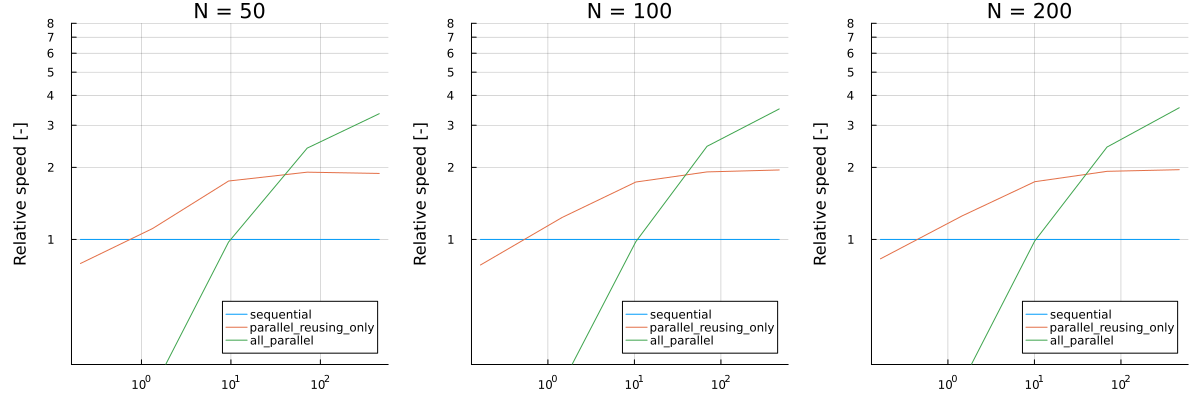

In [106]:
plot(p1, p2, p3, layout = (1, 3), size = (1200, 400), left_margin = 8Plots.mm)